In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.linalg import sqrtm, inv

def symmetrize(X):
    return np.real((X + X.T) / 2)

import torch

from scipy.stats import ortho_group


class Transformer(object):
    def __init__(self, device='cuda'):
        self.device = device

class LinearTransformer(Transformer):
    def __init__(
        self, base_sampler, weight, bias=None,
        device='cuda'
    ):
        super(LinearTransformer, self).__init__(device=device)
        self.base_sampler = base_sampler

        self.weight = torch.tensor(weight, device=device, dtype=torch.float32)
        if bias is not None:
            self.bias = torch.tensor(bias, device=device, dtype=torch.float32)
        else:
            self.bias = torch.zeros(self.weight.size(0), device=device, dtype=torch.float32)

    def sample(self, size=4):
        batch = torch.tensor(
            self.base_sampler.sample(size),
            device=self.device
        )
        with torch.no_grad():
            batch = batch @ self.weight.T
            if self.bias is not None:
                batch += self.bias
        return batch


class Sampler:
    def __init__(
        self, device='cuda',
    ):
        self.device = device

    def sample(self, size=5):
        pass

class StandardNormalSampler(Sampler):
    def __init__(self, dim=1, device='cuda'):
        super(StandardNormalSampler, self).__init__(device=device)
        self.dim = dim

    def sample(self, batch_size=10):
        return torch.randn(batch_size, self.dim, device=self.device)


def compute_KL(true_plan_sigma, predicted_plan_sigma):
  predicted_plan_sigma_inv = symmetrize(inv(predicted_plan_sigma))
  D = true_plan_sigma.shape[0]

  KL = 0.5*(np.log(np.linalg.det(predicted_plan_sigma)) - np.log(np.linalg.det(true_plan_sigma)) - D +
       np.trace(predicted_plan_sigma_inv@true_plan_sigma))

  return KL

from matplotlib import pyplot as plt


def symmetrize(X):
    return np.real((X + X.T) / 2)

def get_D_sigma(covariance_0, covariance_T, epsilon):
    shape = covariance_0.shape[0]

    covariance_0_sqrt = symmetrize(sqrtm(covariance_0))
    return symmetrize(sqrtm(4*covariance_0_sqrt@covariance_T@covariance_0_sqrt + (epsilon**2)*np.eye(shape)))

def get_C_sigma(covariance_0, D_sigma, epsilon):
    shape = covariance_0.shape[0]

    covariance_0_sqrt = symmetrize(sqrtm(covariance_0))
    covariance_0_sqrt_inv = inv(covariance_0_sqrt)

    return 0.5*(covariance_0_sqrt@D_sigma@covariance_0_sqrt_inv - epsilon*np.eye(shape))

def get_mu_t(t, mu_0, mu_T):
    return (1 - t)*mu_0 + t*mu_T

def get_covariance_t(t, covariance_0, covariance_T, C_sigma, epsilon):
    shape = covariance_0.shape[0]

    return (
        ((1-t)**2)*covariance_0 + (t**2)*covariance_T +
        t*(1-t)*(C_sigma+C_sigma.T) + epsilon*t*(1-t)*np.eye(shape)
    )

def get_conditional_covariance_t(t, covariance_0, covariance_T, C_sigma, epsilon):
    shape = covariance_0.shape[0]

    covariance_0_inv = inv(covariance_0)

    return (
        (t**2)*(covariance_T - C_sigma.T@covariance_0_inv@C_sigma) +
        epsilon*t*(1-t)*np.eye(shape)
    )


def get_conditional_mu_t(x0, mu_0, mu_T, t, covariance_0, C_sigma, epsilon):
    shape = covariance_0.shape[0]

    covariance_0_inv = inv(covariance_0)

    return (
        (1-t)*x0 + t*(mu_T + C_sigma.T@covariance_0_inv@(x0[:, None] - mu_0[:, None]))
    )


def get_optimal_plan_covariance(covariance_0, covariance_T, C_sigma):
    size = covariance_0.shape[0]
    optimal_plan_covariance = np.zeros((2*size, 2*size))

    optimal_plan_covariance[:size, :size] = covariance_0
    optimal_plan_covariance[size:, size:] = covariance_T

    optimal_plan_covariance[:size, size:] = C_sigma
    optimal_plan_covariance[size:, :size] = C_sigma.T

    return optimal_plan_covariance


def compute_BW_UVP(samples, true_mu, true_covariance):
    samples_covariance = np.cov(samples.T)
    samples_mu = samples.mean(axis=0)
    samples_covariance_sqrt = symmetrize(sqrtm(samples_covariance))

    mu_term = 0.5*((true_mu - samples_mu)**2).sum()
    covariance_term = (
        0.5*np.trace(samples_covariance) +
        0.5*np.trace(true_covariance) -
        np.trace(symmetrize(sqrtm(samples_covariance_sqrt@true_covariance@samples_covariance_sqrt)))
    )

    BW = mu_term + covariance_term
    BW_UVP = 100*(BW/(0.5*np.trace(true_covariance)))

    return BW_UVP

In [ ]:
# init gaussians

def solve_bridge_matching(DIM, EPSILON, N, ITERATIONS):
  # DIM = 2
  # EPSILON = 100.0
  # N = 3

  N_STEPS = N - 1
  D = DIM
  ITERATIONS = ITERATIONS
  OUTPUT_SEED = 42

  np.random.seed(OUTPUT_SEED)
  torch.manual_seed(OUTPUT_SEED)

  mu_0 = np.zeros(DIM)
  mu_T = np.zeros(DIM)
  mu_optimal_plan = np.stack((mu_0, mu_T), axis=0)

  rotation_Y = ortho_group.rvs(DIM)
  weight_Y = rotation_Y @ np.diag(np.exp(np.linspace(np.log(0.5), np.log(2), DIM)))
  sigma_Y = weight_Y @ weight_Y.T
  Y_sampler = LinearTransformer(StandardNormalSampler(dim=DIM, device="cpu"), weight_Y, bias=None, device="cpu")

  rotation_X = ortho_group.rvs(DIM)
  weight_X = rotation_X @ np.diag(np.exp(np.linspace(np.log(0.5), np.log(2), DIM)))
  sigma_X = weight_X @ weight_X.T
  X_sampler = LinearTransformer(StandardNormalSampler(dim=DIM, device="cpu"), weight_X, bias=None, device="cpu")

  X = X_sampler.sample(100000).cpu().detach().numpy()
  Var_X = np.sum(np.var(X, axis=0))
  # print('Variance of X:', Var_X)

  Y = Y_sampler.sample(100000).cpu().detach().numpy()
  Var_Y = np.sum(np.var(Y, axis=0))
  # print('Variance of Y:', np.sum(Var_Y))

  torch.cuda.empty_cache()

  covariance_0 = sigma_X
  covariance_T = sigma_Y

  D_sigma = get_D_sigma(covariance_0, covariance_T, EPSILON)
  C_sigma = get_C_sigma(covariance_0, D_sigma, EPSILON)

  mu_t = np.stack(
      [get_mu_t(t, mu_0, mu_T) for t in np.linspace(0, 1, N_STEPS+1)], axis=0
  )

  covariance_t = np.stack(
      [get_covariance_t(t, covariance_0, covariance_T, C_sigma, EPSILON) for t in np.linspace(0, 1, N_STEPS+1)],
      axis=0
  )

  optimal_plan_covariance = get_optimal_plan_covariance(covariance_0, covariance_T, C_sigma)

  eps = EPSILON

  times = np.linspace(0, 1, N)

  mu_0 = mu_0
  mu_1 = mu_T

  sigma_0 = sigma_X
  sigma_1 = sigma_Y

  plan_sigma = np.zeros((2*D, 2*D))
  plan_sigma[:D, :D] = sigma_0
  plan_sigma[D:, D:] = sigma_1

  brownian_bridge_sigma = np.zeros((D*(N-2), D*(N-2)))

  for i in range(N-2):
    for j in range(N-2):
      t_less, t_bigger = times[i+1], times[j+1]
      if t_less > t_bigger:
        t_less, t_bigger = t_bigger, t_less

      brownian_bridge_sigma[i*D:(i+1)*D, j*D:(j+1)*D] = eps*t_less*(1-t_bigger)*np.eye(D)

  T = np.zeros(((N-2)*D, 2*D))

  for j, t in enumerate(times[1:-1]):
    T[j*D:(j+1)*D, 0:D] = (1-t)*np.eye(D)
    T[j*D:(j+1)*D, D:] = t*np.eye(D)

  index_map = {1:N-2, N:N-1}
  index_map.update({i:i-2 for i in range(2, N)})

  def compute_Btn(sigma_full, index_map, n):
    i = index_map[n]
    j = index_map[n+1]

    sigma_tn_tn_inv = symmetrize(inv(sigma_full[i*D:(i+1)*D, i*D:(i+1)*D]))
    sigma_tn_tn_plus_1_T = (sigma_full[i*D:(i+1)*D, j*D:(j+1)*D])

    return sigma_tn_tn_plus_1_T@sigma_tn_tn_inv


  # iteration

  KL_log = []

  for iter in range(ITERATIONS):
    sigma_full = np.zeros((D*N, D*N))
    sigma_full[D*(N-2):, D*(N-2):] = plan_sigma
    sigma_full[:D*(N-2), :D*(N-2)] = T@plan_sigma@T.T + brownian_bridge_sigma

    sigma_full[:D*(N-2), D*(N-2):] = T@plan_sigma
    sigma_full[D*(N-2):, :D*(N-2)] = (T@plan_sigma).T

    sigma = sigma_0
    for i in range(1, N):
      sigma = compute_Btn(sigma_full, index_map, i)@sigma

    plan_sigma[:D, D:] = sigma.T
    plan_sigma[D:, :D] = sigma

    KL = compute_KL(plan_sigma, optimal_plan_covariance)
    KL_log.append(KL)

    plan_sigma[:D, D:] = sigma
    plan_sigma[D:, :D] = sigma.T

  return np.array(KL_log)

<ipython-input-1-5ba8cfd9ae88>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(


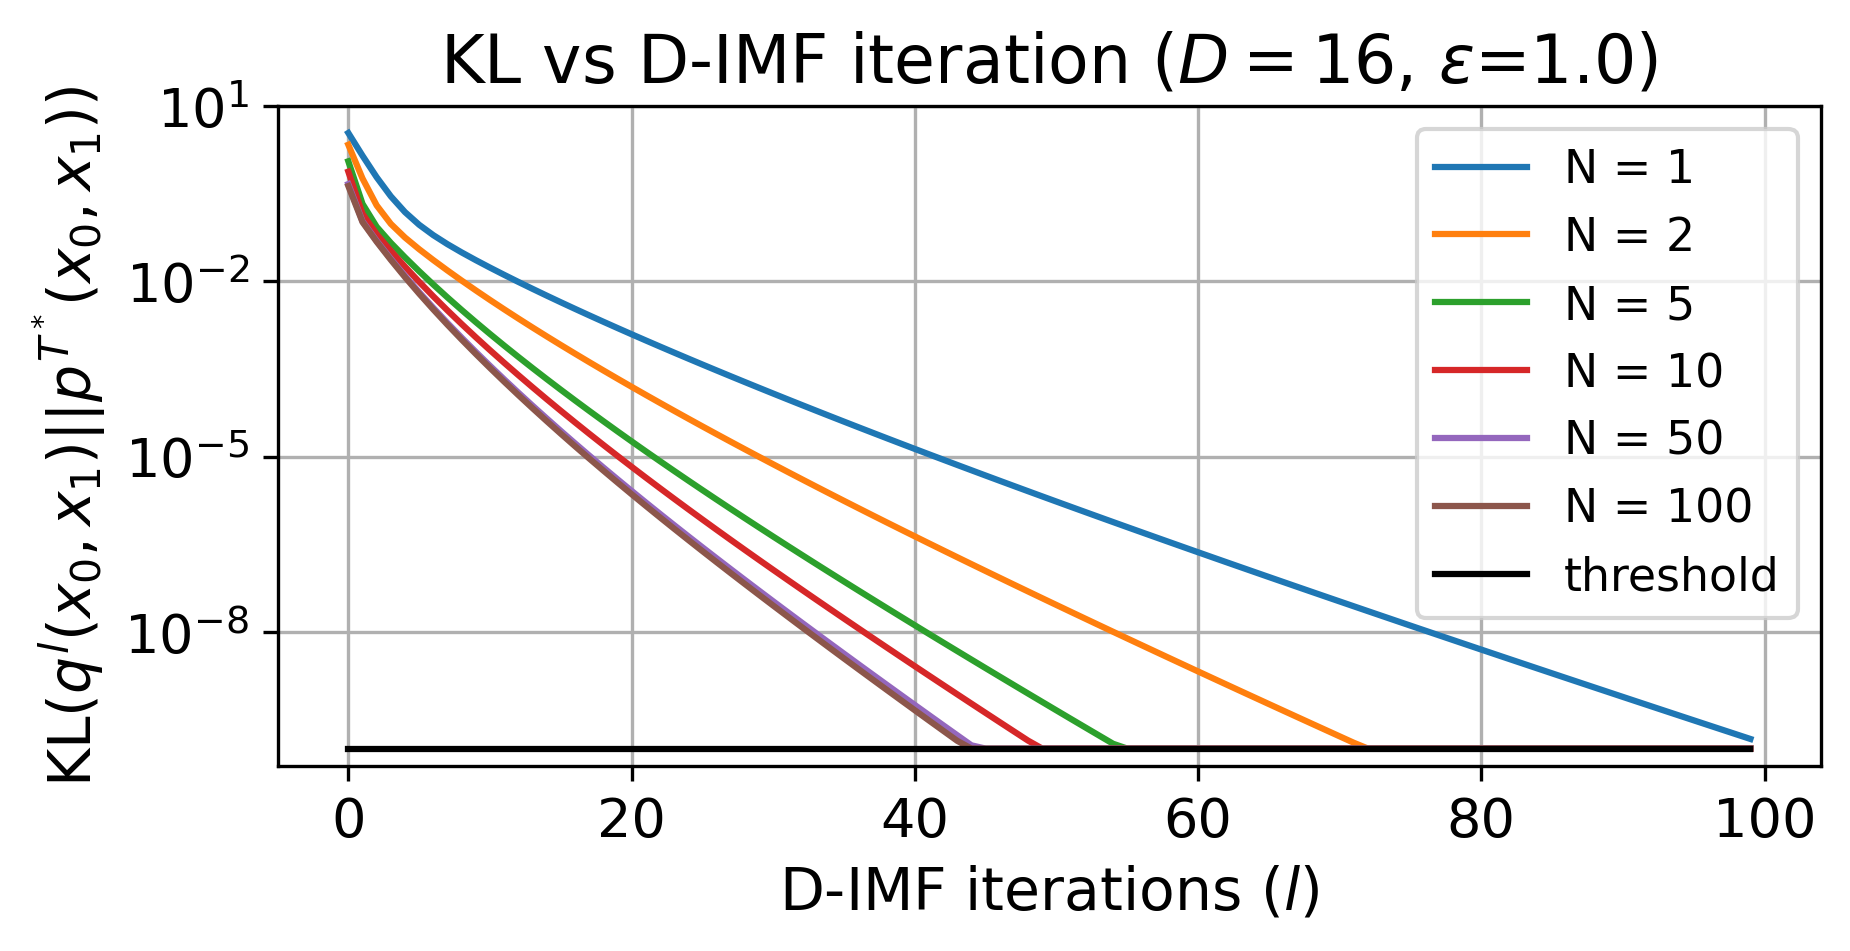

In [ ]:
import matplotlib

intermedite_points = [1, 2, 5, 10, 50, 100]
KLs = {}

matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)

for intermedite_point in intermedite_points:
  KL = solve_bridge_matching(DIM=16, EPSILON=1.0, N=intermedite_point+2, ITERATIONS=100)
  KLs[intermedite_point] = KL

for intermedite_point, KL in KLs.items():
  ax.plot(np.maximum(np.array(KL), np.ones(len(KL))*(1e-10)), label=f"N = {intermedite_point}")

  ax.set_ylim([5*1e-11, 10])
  ax.set_xlabel(r"D-IMF iterations ($l$)", fontsize=14)
  ax.set_ylabel(r"KL($q^{l}(x_0, x_1)||p^{T^*}(x_0, x_1)$)", fontsize=14)
  ax.set_yscale('log')
  ax.set_title(r"KL vs D-IMF iteration ($D=16$, $\epsilon$=1.0)", fontsize=16)

ax.plot(np.array(100*[1e-10]), c="black", label='threshold')
ax.legend(prop={'size': 11})
ax.grid()
fig.tight_layout(pad=0.1)
plt.savefig(f"gauss_dependence_N.png")
# plt.show()

<ipython-input-1-5ba8cfd9ae88>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(


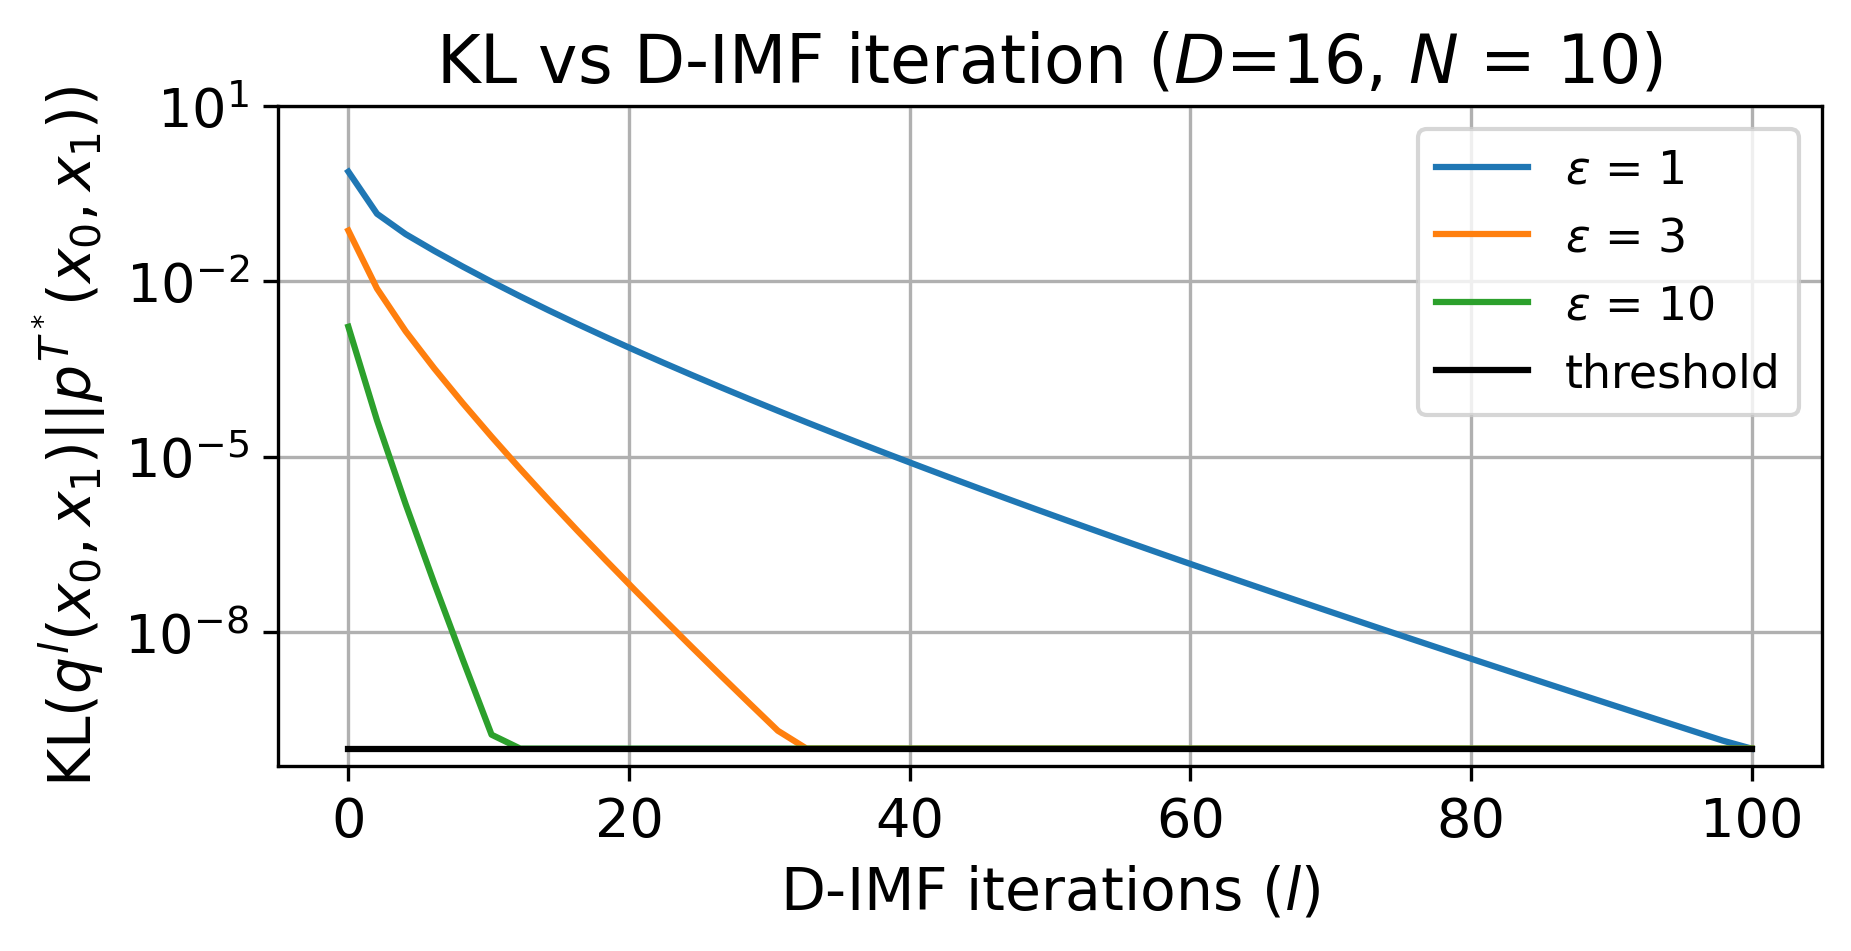

In [ ]:
import matplotlib

# style.use('ggplot')

epses = [1, 3, 10]
KLs = {}

for eps in epses:
  KL = solve_bridge_matching(DIM=16, EPSILON=eps, N=12, ITERATIONS=500)
  KLs[eps] = KL[:50]

matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)

for eps, KL in KLs.items():
  ax.plot(np.linspace(0, 2*KL.shape[0], KL.shape[0]),
          np.maximum(np.array(KL), np.ones(len(KL))*(1e-10)),
          label=r"$\epsilon$" + f" = {eps}")

  ax.set_ylim([5*1e-11, 10.0])
  ax.set_xlabel(r"D-IMF iterations ($l$)", fontsize=14)
  ax.set_ylabel(r"KL($q^{l}(x_0, x_1)||p^{T^*}(x_0, x_1)$)", fontsize=14)
  ax.set_yscale('log')
  ax.set_title(r"KL vs D-IMF iteration ($D$=16, $N$ = 10)", fontsize=16)
  # ax.legend(prop={'size': 12})

ax.plot(np.array(101*[1e-10]), c="black", label='threshold')
ax.legend(prop={'size': 11})
ax.grid()
fig.tight_layout(pad=0.1)
plt.savefig(f"gauss_dependence_eps.png")